In [3]:
!pip install python-opencv_contrib

^C


In [ ]:
import numpy as np
import gym 
import utils.sim as vrep
from utils.base import VrepEnv
import imageio
import time
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
env = VrepEnv("127.0.0.1", 19997)

env.connect()

Connection to client successful. IP: 127.0.0.1, port: 19997, client id: 0


100%|██████████| 200/200 [04:21<00:00,  1.31s/it]


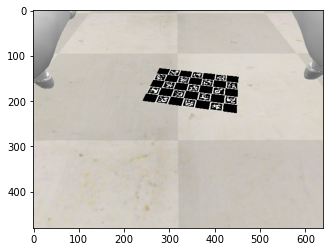

In [3]:
env.start_simulation()

cameraHandle = env.get_handle("NAO_vision2")

no_of_frame = 200
images = []
for frame in tqdm(range(no_of_frame)):

    env.step_simulation()
    errorCode, resolution, image_raw = env.get_vision_image(cameraHandle)
     
    if(len(image_raw)>0):
        image = np.array(image_raw, dtype=np.uint8).reshape((resolution[1],resolution[0],3))
        mid = (resolution[0]/2 ,resolution[1]/2)
        
        imag = cv2.flip(image, 0)
        images.append(imag)
        # cv2.imshow("Actual", imag)
        # cv2.waitKey()
        # cv2.destroyAllWindows()
        plt.imshow(imag)
        # plt.show()
        time.sleep(1)
        clear_output(wait=True)
        # print(frame)


In [4]:
# Write video
imageio.mimsave('cam-calibrate_4.mp4', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

In [5]:
#Close Environment
env.close()

In [3]:
imageio.mimsave('cam-calibrate.mp4', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)

NameError: name 'images' is not defined

In [2]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))

In [3]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(decimator))
        cv2.imwrite("workdir\\data_CoppeliaSim\\image_{0}.jpg".format(decimator),im)
        frame = im # cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [4]:
allCorners,allIds,imsize=read_chessboards(images)

NameError: name 'images' is not defined

In [8]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    #flags = (cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [9]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
Wall time: 2.29 s


In [ ]:
# grabing video and write it's frames as images to file
workdir = "./icream_video/image"
vid = cv2.VideoCapture("icream_video/ice_video_20201210-151219.webm")
cnt = 0
while(vid.isOpened()):
    ret, frame = vid.read()
    if ret == True:
        
        if((cnt%5)==0):
            cv2.imwrite(workdir+'/image_{0}_{0}.jpg'.format(cnt),frame)
            print("Processing Image ",cnt)
        cnt+=1
    else:
        break

In [4]:
workdir = "./workdir/"
datadir = workdir+"data_CoppeliaSim/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
images

array(['./workdir/data_CoppeliaSim/image_0_0.jpg',
       './workdir/data_CoppeliaSim/image_5_5.jpg',
       './workdir/data_CoppeliaSim/image_10_10.jpg',
       './workdir/data_CoppeliaSim/image_15_15.jpg',
       './workdir/data_CoppeliaSim/image_20_20.jpg',
       './workdir/data_CoppeliaSim/image_25_25.jpg',
       './workdir/data_CoppeliaSim/image_30_30.jpg',
       './workdir/data_CoppeliaSim/image_35_35.jpg',
       './workdir/data_CoppeliaSim/image_40_40.jpg',
       './workdir/data_CoppeliaSim/image_45_45.jpg',
       './workdir/data_CoppeliaSim/image_50_50.jpg',
       './workdir/data_CoppeliaSim/image_55_55.jpg',
       './workdir/data_CoppeliaSim/image_60_60.jpg',
       './workdir/data_CoppeliaSim/image_65_65.jpg',
       './workdir/data_CoppeliaSim/image_70_70.jpg',
       './workdir/data_CoppeliaSim/image_75_75.jpg',
       './workdir/data_CoppeliaSim/image_80_80.jpg',
       './workdir/data_CoppeliaSim/image_85_85.jpg',
       './workdir/data_CoppeliaSim/image_90_90.jpg

In [5]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [6]:
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image ./workdir/data_CoppeliaSim/image_0_0.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_5_5.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_10_10.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_15_15.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_20_20.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_25_25.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_30_30.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_35_35.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_40_40.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_45_45.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_50_50.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_55_55.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_60_60.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_65_65.jpg
=> Processing image ./workdir/data_CoppeliaSim/image_70_70.jpg
=> Processing image ./workdir/data_

In [10]:
ret

1.8079051051666362

In [11]:
mtx

array([[735.74707364,   0.        , 234.99105642],
       [  0.        , 735.74707364, 279.17366142],
       [  0.        ,   0.        ,   1.        ]])

In [12]:
dist

array([[-1.70684743e-01],
       [-1.85234048e+01],
       [-1.06481606e-02],
       [-2.70800237e-02],
       [-7.96032968e+02],
       [-2.79451507e-01],
       [-1.87203523e+01],
       [-7.83109701e+02],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00]])

In [16]:
# read from coppeliaSim

env = VrepEnv("127.0.0.1", 19997)

env.connect()
env.start_simulation()

# cameraHandle = env.get_handle("Vision_sensor")
cameraHandle = env.get_handle("NAO_vision1#0")


vid = cv2.VideoCapture(1)
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

frame_height = 512
frame_width = 512

videoOut = cv2.VideoWriter("CoppeliaSim_outputPose.avi", cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width, frame_height))
temp = []
while True:

    env.step_simulation()
    errorCode, resolution, image_raw = env.get_vision_image(cameraHandle)
    # print(len(image_raw))
    if(len(image_raw)>0):
        image = np.array(image_raw, dtype=np.uint8).reshape((resolution[1],resolution[0],3))
        mid = (resolution[0]/2 ,resolution[1]/2)
        
        imag = cv2.flip(image, 0)
        # images.append(imag)
        frame = imag.copy()
        # detect ArUcO marker
        markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(frame,dictionary)
        img_clone =  frame.copy()
        # Display the detected markers
        img_clone = cv2.aruco.drawDetectedMarkers(img_clone, markerCorners, markerIds)
        #estinate pose
        size_of_marker =  0.033 # side lenght of the marker in meter
        rvecs,tvecs,_ = aruco.estimatePoseSingleMarkers(markerCorners, size_of_marker , mtx, dist)

        length_of_axis = 0.01
        imaxis = aruco.drawDetectedMarkers(frame.copy(), markerCorners, markerIds)
        if(tvecs is not None):
            for i in range(len(tvecs)):
                imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

        cv2.imshow("image",np.hstack((frame,imaxis)))#; cv2.waitKey(); cv2.destroyAllWindows()
        videoOut.write(imaxis)
        temp.append(imaxis)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            env.close()
            break
    else:
        break
# vid.release()
videoOut.release()

Connection to client successful. IP: 127.0.0.1, port: 19997, client id: 0


In [18]:
imageio.mimsave('CoppeliaSim_outputPose.mp4', [np.array(img) for i, img in enumerate(temp) if i%2 == 0], fps=29)
env.close()
cv2.destroyAllWindows()
vid.release()
videoOut.release()